In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import glob
import datetime as dt

path = 'Renewable Energy Data/Rajasthan1'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename,index_col=None, header=0,skiprows=2,usecols=[0,1,2,3,4,7])
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

frame['Date']=frame['Year'].astype(str) + frame['Month'].astype(str).str.zfill(2) + frame['Day'].astype(str).str.zfill(2) + frame['Hour'].astype(str).str.zfill(2)+frame['Minute'].astype(str)

frame['Date'] = pd.to_datetime(frame['Date'], format='%Y%m%d%H%M')

df_all = frame[['Date','GHI']]
df_all.set_index('Date',inplace=True)
df_all = df_all.between_time('09:00','15:00')
df_all.fillna(df_all.mean(),inplace=True)
y=df_all['GHI'].resample('W-MON').mean()

<AxesSubplot:title={'center':'Time Series Plot'}, xlabel='Date'>

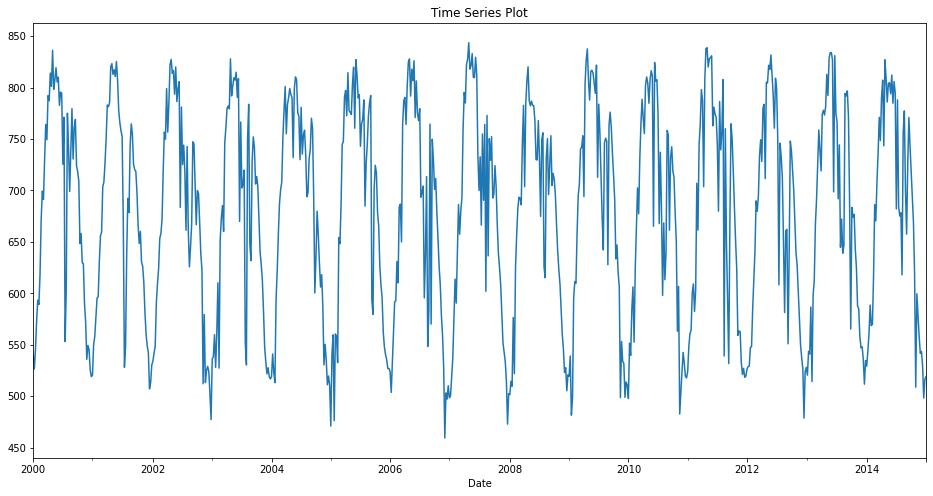

In [3]:
y.plot(figsize=[16,8],title='Time Series Plot')

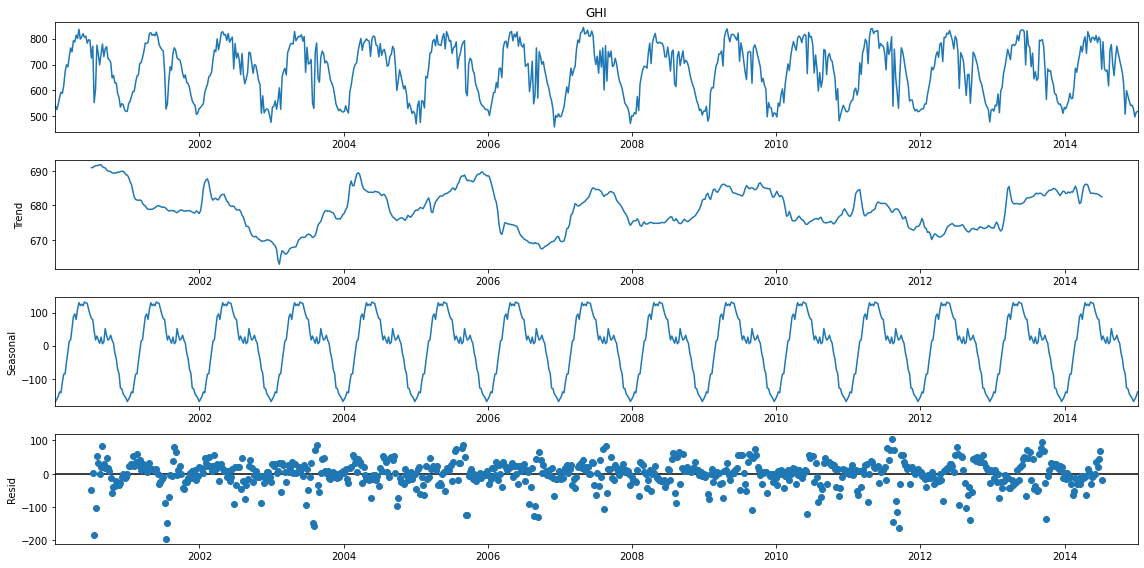

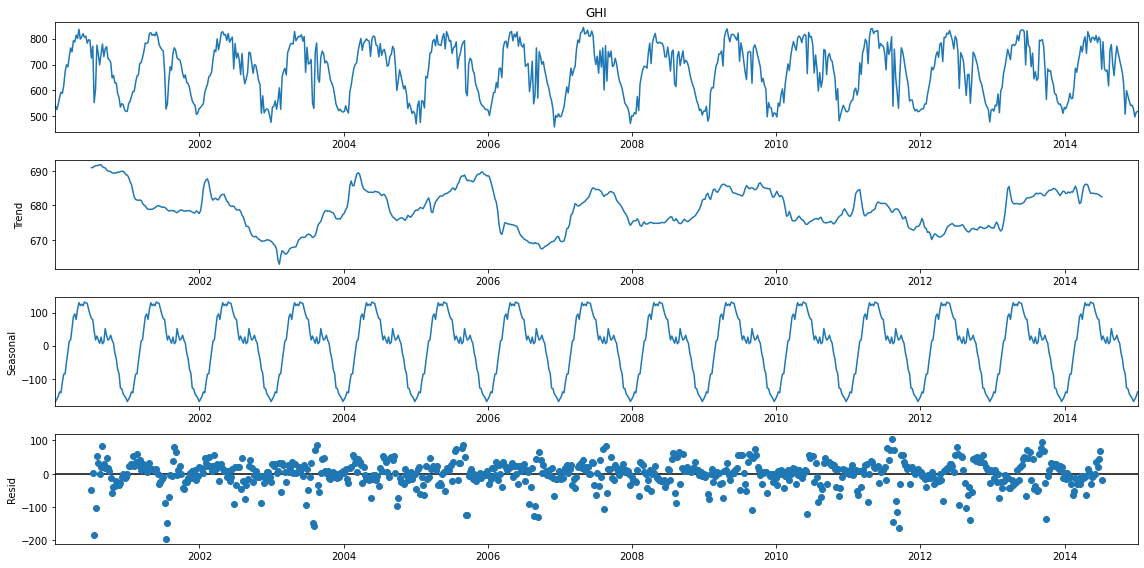

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pylab

result=seasonal_decompose(y,model='additive')
pylab.rcParams['figure.figsize'] = (16, 8)
result.plot()

In [5]:
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm

mod2 = sm.tsa.statespace.SARIMAX(y['2000':'2012'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), enforce_stationarity=False, enforce_invertibility=False)
results2 = mod2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                GHI   No. Observations:                  679
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -2979.868
Date:                            Mon, 23 Nov 2020   AIC                           5969.736
Time:                                    10:25:20   BIC                           5991.481
Sample:                                01-03-2000   HQIC                          5978.219
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2541      0.027      9.473      0.000       0.202       0.307
ma.L1         -1.0000     21.936     -0.046      0.964     -43.995      41.995
ar.S.L52       0.0789      0.020      3.957      0.000       0.040       0.118
ma.S.L52      -1.1361      0.072    -15.837      0.000      -1.277      -0.996
sigma2      1352.1836   2.97e+04      0.046      0.964   -5.68e+04    5.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               228.16
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.70
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

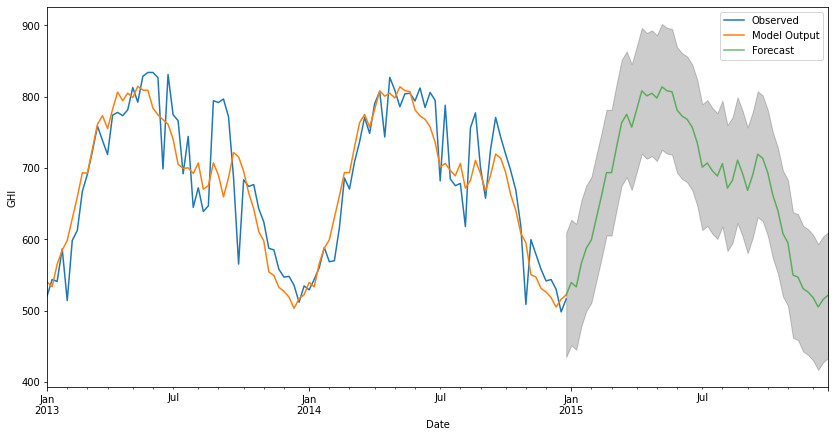

In [6]:
pred = results2.get_prediction(start=pd.to_datetime('2013-01-07'),end=pd.to_datetime('2014-12-29'), dynamic=False)

#Plot observed data
ax = y['2013':'2014'].plot(label='Observed')

#Plot predicted data
pred.predicted_mean.plot(ax=ax, label='Model Output', alpha=1, figsize=(14, 7))

#Generate a confidence interval
#pred_ci = pred.conf_int()
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)


forecast = results2.get_prediction(start=pd.to_datetime('2014-12-29'),end=pd.to_datetime('2015-12-28'), dynamic=False)
forecast_ci = forecast.conf_int()
forecast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('GHI')
plt.legend()
plt.show()

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
y_forecasted = pred.predicted_mean
y_truth = y['2013-01-07':'2014-12-29']

mean_absolute_percentage_error(y_truth,y_forecasted)

4.7679420403347565